# Understanding `pycheops` using data of KELT-11 II: Preparing the dataset

In this notebook, we demonstrate preparing the dataset, including detrending (or decorrelating) the dataset.

Much of the code in this notebook is taken from [`pycheops-cookbook`](https://github.com/pmaxted/pycheops/blob/master/pycheops/docs/PyCheops_Cookbook.pdf) and from [`pycheops example notebook`](https://github.com/pmaxted/pycheops/blob/master/pycheops/examples/Notebooks/KELT-11b-tutorial.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser

## Downloading the data

Found archive tgzfile /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200.tgz
 PI name     : Andrea FORTIER
 OBS ID      : 1015981
 Target      : KELT-11b
 Coordinates : 10:46:49.74 -09:23:56.5
 Spec. type  : G9V
 G magnitude : 7.83 +- 0.03
Light curve data loaded from  /home/jayshil/.local/share/pycheops/CH_PR300024_TG000101_V0200-OPTIMAL.fits
Time stored relative to BJD = 2458918
Aperture radius used = 28 arcsec
UTC start:  2020-03-09T14:50:41
UTC end:    2020-03-10T04:44:34
Visit duration: 50033 s
Exposure time: 2 x 15.0 s
Number of non-flagged data points: 1535
Efficiency (non-flagged data): 92.0 %
Light curve corrected for flux from background stars
C_cut = 39629816
N(C > C_cut) = 4
Mean counts = 39495521.5
Median counts = 39511341.9
RMS counts = 46070.5 [1166 ppm]
Median standard error = 6331.7 [160 ppm]
Median background = 358931 e-/pxl
Mean contamination = 40.4 ppm
Mean smearing correction = 19.4 ppm
Predicted amplitude of ramp = 71 ppm


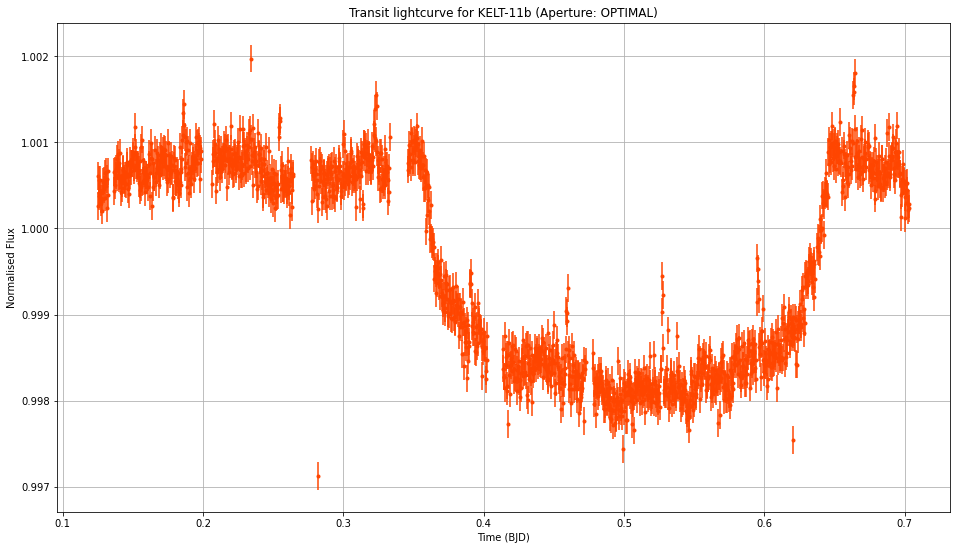

In [2]:
# Downloading data
dd = pycheops.Dataset('CH_PR300024_TG000101_V0200')
tim, fl, fle = dd.get_lightcurve(aperture='OPTIMAL', decontaminate=True, reject_highpoints=True)

# To clip outliers (I would, in general, not prefer using this)
# tim, fl, fle = dd.clip_outliers(clip=5)

# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

### Planetary check

We may want to check the position of various planetary bodies with respect to the target star, because if some of the bodies is very near to the target star then we may want to correct for their effects.

In [3]:
dd.planet_check()

BJD = 2458918.124880498
Body     R.A.         Declination  Sep(deg)
-------------------------------------------
Moon     11:21:44.78  +09:19:29.6      16.0
Mars     19:05:24.57  -23:08:38.0      81.6
Jupiter  19:29:58.34  -21:50:58.1     113.6
Saturn   20:03:17.21  -20:27:01.5     125.8
Uranus   02:06:47.07  +12:20:30.2     129.0
Neptune  23:18:02.79  -05:36:58.0     163.1


## Stellar and Planetary properties

A knowledge of the stellar and planetary property of the system under investigation can proved to be useful while analysing the system. We can use some of the properties as priors in our analysis. In `pycheops` there are some in-build tools  available which ca go through the available stellar and planetary catalogues (like SWEET-Cat, or DACE) to give us the properties. Below, we show how to access such properties.

In [4]:
# For planetary properties
# This cell is copied from pycheops examples notebook

DACE = True  # Set true if you have access to the planet properties table through your .dacerc file

if DACE:    
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=True)
else:
    from uncertainties import ufloat
    Kelt11b = pycheops.PlanetProperties('KELT-11b',query_dace=False,
                                    depth = ufloat(2200, 100),   # PPM
                                    width = ufloat(0.2974,0.0001),  # days
                                    ecosw=ufloat(-0.0040, 0.0490), 
                                    esinw=ufloat(0.0310, 0.0680),
                                    T0 = ufloat(2458260.168608, 0.000030),
                                    P = ufloat(4.73620495, 0.00000086))
    
print(Kelt11b)

2021-10-24 17:33:57,666 - ERROR - Forbidden. You do not have the permission to access these data


No matching planet in DACE-Planets.
List of valid planet_id keys:


2021-10-24 17:33:59,558 - ERROR - Forbidden. You do not have the permission to access these data


[]
Identifier : KELT-11b
T0 : 2458260.1686 +/- 0.0000 BJD       [TEPCat]
P :     4.7362050 +/- 0.0000009 days   [TEPCat]
depth :  2200.0000 +/- 100.0000 ppm         [TEPCat]
width :  0.2974 +/- 0.0100 days            [TEPCat]



Well..., apparently, I cannot (even after studying two semesters at Geneva) access DACE-Planets. No problem --- we have TEPCat at our service. We derived parameters from there. We can now try searching for the host star.

In [5]:
star = pycheops.StarProperties(dd.target)
print(star)

Identifier : KELT-11b
Coordinates: 10:46:49.74 -09:23:56.5
T_eff :  5370 +/-  50 K   [SWEET-Cat]
log g :  3.73 +/- 0.04    [SWEET-Cat]
[M/H] : +0.18 +/- 0.07    [SWEET-Cat]
log rho : -1.17 +/- 0.08  (solar units)
h_1 : 0.715 +/- 0.011     [Stagger]
h_2 : 0.442 +/- 0.050     [Stagger]



We have it! Here `h_1` and `h_2` are power2 law limb darkening coefficients.

## Renormalising the lightcurve

By a careful observation of the KELT-11 lightcurve, it can be observed that the out-of-transit values of the lightcurve is not equal to unity. So we may want to flatten the lightcurve using the `dataset.flatten` command as below,

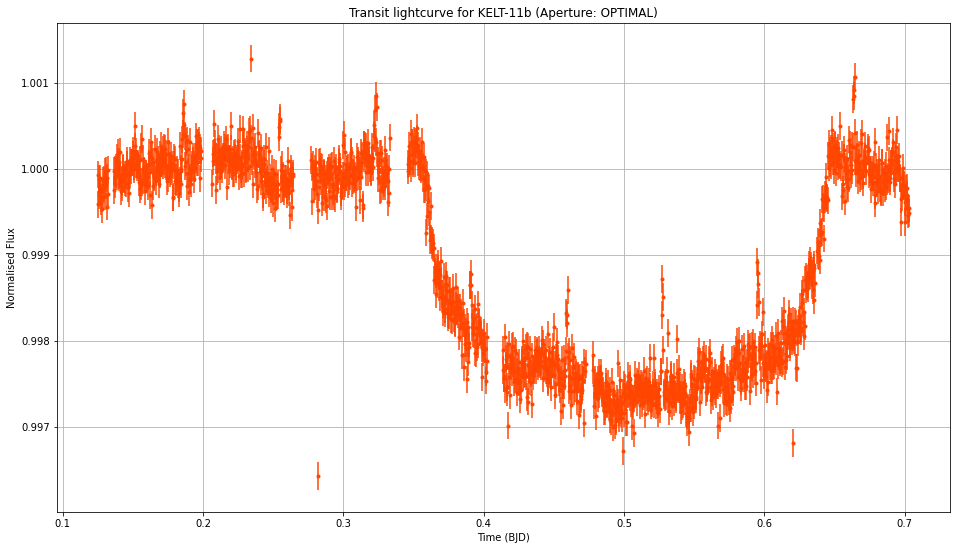

In [6]:
# This code is taken from the pycheops example notebook
P = Kelt11b.P.n
BJD_0 = Kelt11b.T0.n
cycle = round((dd.bjd_ref-BJD_0)/P)
T_0 = BJD_0 - dd.bjd_ref + cycle*P

D = Kelt11b.depth.n/1e6  # Depth stored in ppm
W = Kelt11b.width.n/P    # Width stored in days

if Kelt11b.f_c and Kelt11b.f_s:
    f_c = Kelt11b.f_c
    f_s = Kelt11b.f_s
else:
    # From Pepper et al., 2017
    ecosw = ufloat(-0.004,0.05099)
    esinw = ufloat(0.031,0.055)
    ecc = usqrt(ecosw**2+esinw**2)
    f_s = esinw/usqrt(ecc)  # f_s = sqrt(e)sin(omega) = e.sin(omega)/sqrt(e)
    f_c = ecosw/usqrt(ecc)  # f_c = sqrt(e)cos(omega) = e.cos(omega)/sqrt(e)


tim, fl, fle = dd.flatten(T_0, P*W)
# Plotting the data
plt.figure(figsize=(16,9))
plt.errorbar(tim, fl, yerr=fle, fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

## Detrending (or, decorrelating) the dataset

To perform this operation of detrending we may want to look at diagnostic report for this observations. The diagnostic report consist of various plots of flux as a function of several instrumental properties like roll angle of the spacecraft, centroid position etc. This would enable us to see if there is any trend going on with instruments so that we can take care of it. So, first let's see the diagnostic report...

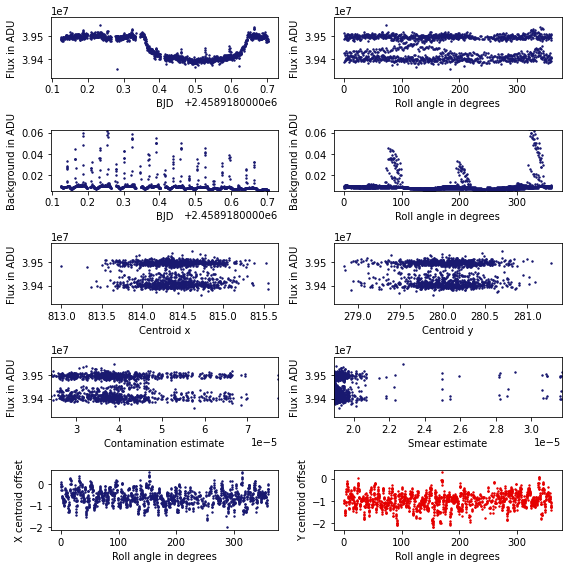

In [7]:
dd.diagnostic_plot()

### Ramp correction
A ramp in the flux is often observed, usually beginning the visit, in the lightcurves due to thermal effects (well, it primarily occurs due to small scale change in the shape of the PSF, which happens due to slightly more defocusing of the telescope. The main reason for the later is the thermal effects). The effect is well characterised for aperture radius between ~22 to 40 pixels. We can correct for this effect using the function `dataset.correct_ramp`.

Note that since this effect is well described only for a range of pixels, it is not advisable to make this correction if the aperture size is beyond this range.

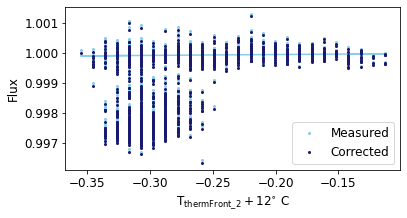

In [8]:
tim, fl, fle = dd.correct_ramp(plot=True)

### Should I decorrelate?

In [9]:
# Run the decorrelation tool to assess if there are any trends in the data
# that should be removed.
dd.should_I_decorr()

Decorrelate in dfdt dfdx dfdy dfdsinphi dfdcosphi dfdbg dfdcontam dfdsmear d2fdt2 d2fdx2 d2fdy2 dfdsin2phi dfdcos2phi using decorr, lmfit_transt, or lmfit_eclipse functions.


(-21628.656365871262,
 ['dfdt',
  'dfdx',
  'dfdy',
  'dfdsinphi',
  'dfdcosphi',
  'dfdbg',
  'dfdcontam',
  'dfdsmear',
  'd2fdt2',
  'd2fdx2',
  'd2fdy2',
  'dfdsin2phi',
  'dfdcos2phi'])

### Performing decorrelation

We can see above that, `Dataset.should_I_decorr` function suggests that several decorrelations should be done. Various parameters shows different correlations with different properties of the instrument. From $\texttt{pycheops-cookbook}$ I mention where each of these parameters belong:

- flux versus time: $\texttt{dfdt}$, $\texttt{d2fdt2}$
- flux versus x-centroid: $\texttt{dfdx}$, $\texttt{d2fdx2}$
- flux versus y-centroid: $\texttt{dfdy}$, $\texttt{d2fdy2}$
- flux versus roll angle: $\texttt{dfdsinphi}$, $\texttt{dfdcosphi}$, $\texttt{dfdsin2phi}$, $\texttt{dfdcos2phi}$, $\texttt{dfdsin3phi}$, $\texttt{dfdcos3phi}$
- flux versus background: $\texttt{dfdbg}$
- flux versus contamination: $\texttt{dfdcontam}$
- flux versus smear: $\texttt{dfdsmear}$

Note that not each of the parameters have same units (especially $\texttt{dfdt}$), therefore, one may want to take care while defining these parameters in analysis.

There are (I think) two ways to take care of these correlations --- we can either use `dataset.decorr` function to take care of these correlations, or we can do it in the later stage of fitting the data. There is a little advantage of doing this in a later stage of curve fitting: if we do at that point, we can see the effect of <i>adding</i> parameters to the fitting with Bayes' factors. We can even neglect additional parameters which are not supported by the data.

However, before jumping to the main fitting, we give an example of the usage of `dataset.decorr` method. We can do so by making boolean `True` for desired parameters described above as the argument of the `dataset.decorr` method. As an example, we try to decorrelate, to the first order, trends in the roll angle.

In [10]:
# fl, fle = dd.decorr(dfdsinphi=True, dfdcosphi=True)
# Since sin(phi) and cos(phi) are the sinus and cosine of the roll angle, if one wants to perform this decorrelation, these two should be used in pair.
# dd.diagnostic_plot()

Well, it indeed seem that, the decorrelation is performed (compare two diagnostic plots).

However, as said previously, we are not going to use this method --- instead, we will try to decorrelate while fitting the model only. That way we can have advantage of knowing Bayes' factor, so that we want include too many redundant parameters while modelling.

Below, we try to include one by one parameter in the model and see its effect on the fitting in form of the Bayes' factor. However, before including decorrelation parameters, we fit <i>without</i> any decorrelation parameters. We can use results from this fitting as priors for the modelling which includes decorrelation parameters.

### Fitting without decorrelation

#### A note on using priors

The priors on the parameters can be find using `uncertainties` or `lmfit` module, or simply by using a tuple. To give normal priors with mean $\mu$ and standard deviation $\sigma^2$, one can use ufloat($\mu$, $\sigma^2$). A uniform prior with upper ($u$) and lower ($l$) bound can be given by a tuple ($l$, $u$), with initial value halfway of the range. If we want to specify the initial value ($in$), we can add it as a third term within the tuple, as ($l$, $u$, $in$). Furthermore, one can use [Parameter](https://lmfit.github.io/lmfit-py/parameters.html#the-parameter-class) object of `lmfit`. It can be defined as,

```
    lmfit.Parameter(name (str) = name of the parameter,
                    value (float) = numerical parameter value,
                    vary (bool) = Whether the parameter is varied during a fit (default is True,)
                    min (float) = lower bound (default is -np.inf),
                    max (float) = upper bound (default is np.inf),
                    expr (str) = mathematical expression used to constrain the value during the fit,
                    ***other kwargs)
```

(-0.001, 0.001)

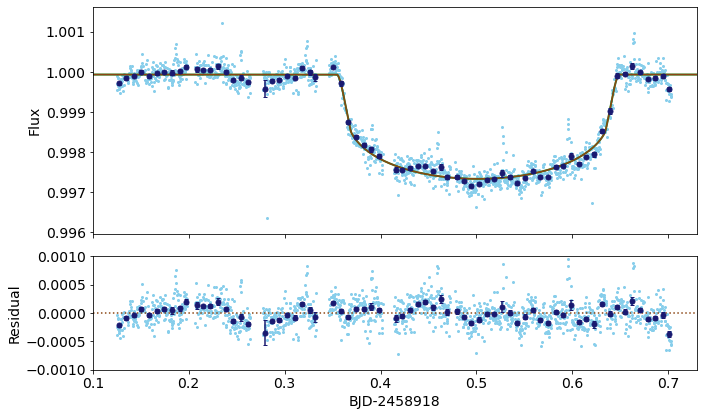

In [11]:
# Codes from the pycheops example notebook
lmfit0 = dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                          D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                          f_c=f_c, f_s=f_s, 
                          h_1=star.h_1, h_2=star.h_2.n,
                          logrhoprior=star.logrho)

dd.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14);
plt.ylim([-0.001, 0.001])

There is it! Our first fit using `pycheops`. We can see the diagnostic report below.

In [12]:
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 181
    # data points      = 1504
    # variables        = 8
    chi-square         = 3720.15942
    reduced chi-square = 2.48673758
    Akaike info crit   = -19785.2877
    Bayesian info crit = -19742.7606
    RMS residual       = 252.8 ppm
[[Variables]]
    T_0:     0.50175738 +/- 0.00157554 (0.31%) (init = 0.5010961)
    P:       4.736205 (fixed)
    D:       0.00214253 +/- 4.1329e-05 (1.93%) (init = 0.0022)
    W:       0.06234171 +/- 0.00109808 (1.76%) (init = 0.06279289)
    b:       0.36386825 +/- 0.08612092 (23.67%) (init = 0.5)
    f_c:    -0.01634318 +/- 0.00821665 (50.28%) (init = -0.02262488)
    f_s:     0.12382111 +/- 0.08079051 (65.25%) (init = 0.1753428)
    h_1:     0.69038145 +/- 0.00875151 (1.27%) (init = 0.715)
    h_2:     0.442 (fixed)
    c:       0.99993378 +/- 9.4295e-06 (0.00%) (init = 1)
    k:       0.04628745 +/- 4.4644e-04 (0.96%) == 'sqrt(D)'
    aR:      5.00876430 +/- 0.2499011

### Fitting with decorrelation

We now attempt to fit the data with decorrelation parameters. As said previously, we add one by one decorrelation parameters in the fitting procedure and check the Bayes' factor each time.

We first want to check the RMS of the residuals which we can use as standard deviation of decorrelation parameters' priors in the fitting.

In [13]:
sigma0 = lmfit0.rms
dprior = ufloat(0, sigma0)
tprior = ufloat(0, sigma0/np.ptp(tim)) # Remember? Some of the priors, like dfdt, has different units.

In [14]:
# This code is taken from pycheops example notebook
detrend = {}
bestbf = 0
allpar = ['dfdsinphi','dfdcosphi',
          'dfdsin2phi','dfdcos2phi',
          'dfdsin3phi','dfdcos3phi',
          'dfdx', 'dfdy', 'dfdsmear',
          'dfdbg','dfdt', 'dfdcontam']

print('Parameter     BF     Delta_BIC RMS(ppm)')

while bestbf < 1:
    bestbf = np.inf
    for p in allpar: # This loop will put one by one parameter in the fit and see which one produce lowest Bayes' factor.
        dtmp = detrend.copy() ## Copy Updated detrend dictionary to temporary dtmp dict
        dtmp[p] = tprior if p == 'dfdt' else dprior
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho, **dtmp)
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf < bestbf:
                bestbf = bf
                newpar = p

    if bestbf < 1: # This condition will add lowest Bayes' factor parameter into detrend dict. if it has Bayes' factor <1
        print(f'+{newpar:<12s} {bestbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')
        detrend[newpar] = tprior if newpar == 'dfdt' else dprior
        allpar.remove(newpar) # If parameter is added to the dict then get removed from list of all parameters

# This process sometimes leads to a set of parameters that includes a few parameters that are strongly correlated with one another 
# and so are therefore not well determined, i.e. they have large Bayes factors. 
# So, after adding parameters one-by-one, go through a process of repeatedly removing the parameter with the largest Bayes factor 
# if any of the parameters have a Bayes factors Bp>1.

worstbf = 10
while worstbf > 1:
    worstbf = 0
    for p in detrend: # This loop finds the parameter with largest Bayes' factor
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf > worstbf:
                worstbf = bf
                delpar = p
    if worstbf > 1: # This condition removes the parameter with largest Bayes' factor if it is >1
        del detrend[delpar] 
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho, **detrend)
        print(f'-{delpar:<12s} {worstbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')

Parameter     BF     Delta_BIC RMS(ppm)
+dfdcosphi      0.00     -27.9    251.6
+dfdbg          0.00     -98.9    248.8
+dfdcos2phi     0.14    -456.5    235.6
+dfdcos3phi     0.19    -468.0    234.9
+dfdcontam      0.22    -488.0    233.9
-dfdcosphi      7.10    -492.7    234.0


The remained parameters which would be useful in decorrelating are (the ones which are stored in `detrend` dictionary). Note that the different between BIC is reducing with each addition/removal of the parameter.

In [15]:
print(detrend)

{'dfdbg': 0.0+/-0.0002528246483432867, 'dfdcos2phi': 0.0+/-0.0002528246483432867, 'dfdcos3phi': 0.0+/-0.0002528246483432867, 'dfdcontam': 0.0+/-0.0002528246483432867}


We can now use this parameters to detrend the dataset using the `lmfit_transit` function.

In [16]:
lmfit1 = dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P,
                          D=(D/4, D, D*4), W=(W/4, W, W*4), b=(0,0.5,1),
                          f_c=f_c, f_s=f_s,
                          h_1=star.h_1, h_2=star.h_2.n,
                          logrhoprior=star.logrho, **detrend)

# Note the usage of .n in star.h_2.n which means that it will retrieve only one value and thus fixing the parameter.
print(dd.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 453
    # data points      = 1504
    # variables        = 12
    chi-square         = 3198.19770
    reduced chi-square = 2.14356414
    Akaike info crit   = -20299.2494
    Bayesian info crit = -20235.4588
    RMS residual       = 234.0 ppm
[[Variables]]
    T_0:         0.50151388 +/- 0.00140724 (0.28%) (init = 0.5010961)
    P:           4.736205 (fixed)
    D:           0.00214885 +/- 1.3083e-05 (0.61%) (init = 0.0022)
    W:           0.06238080 +/- 0.00213473 (3.42%) (init = 0.06279289)
    b:           0.38844244 +/- 0.03647214 (9.39%) (init = 0.5)
    f_c:        -0.02393073 +/- 0.20862482 (871.79%) (init = -0.02262488)
    f_s:         0.14775430 +/- 0.14910390 (100.91%) (init = 0.1753428)
    h_1:         0.69761884 +/- 0.00809381 (1.16%) (init = 0.715)
    h_2:         0.442 (fixed)
    c:           0.99993039 +/- 1.3853e-05 (0.00%) (init = 1)
    dfdbg:       6.3681e-04 +/- 4.5834e-05 (7.20%) (ini

(-0.001, 0.001)

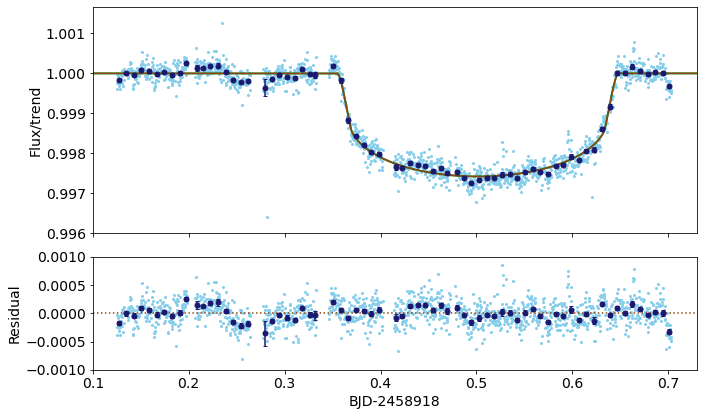

In [17]:
# We can plot the fitting
dd.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True);
plt.ylim([-0.001, 0.001])

In above plot, light blue points are flux/trend, while the dark blue ones are the binned flux/trend. Transit model is shown in green and (transit model/trend) is brown line.

We can now check the roll angle plot to see if there is any trend remains. `dataset.rollangle_plot` gives the plot of residuals in the last fit with respect to the roll angle.

(-0.00075, 0.00075)

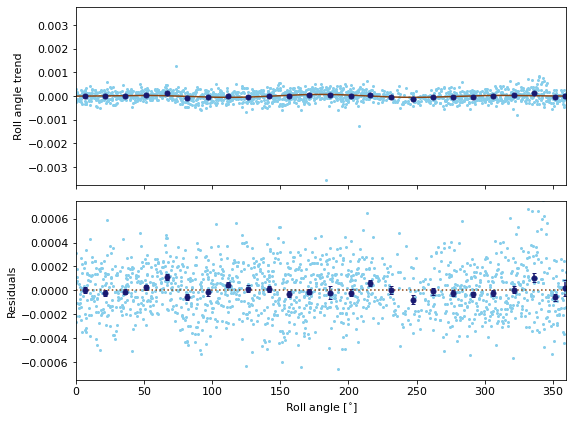

In [18]:
fig = dd.rollangle_plot()
plt.ylim([-0.00075, 0.00075])

#### `add_glint` function
We can see some peculier features around $340^\circ$ and arounf $60^\circ$ of roll angles. We can model these features with `add_glint` function of `pycheops`. This function will calculate a spline fit to the residuals. Let's see how well it can perform,

(-0.001, 0.001)

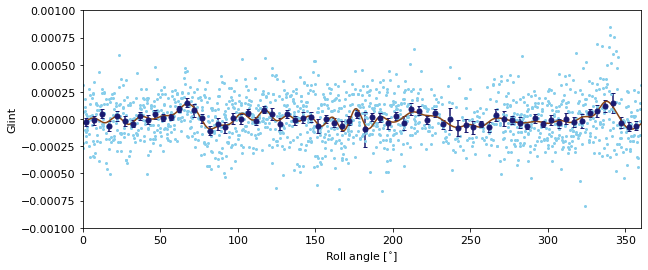

In [19]:
glint_func = dd.add_glint(nspline=48,binwidth=5,figsize=(10,4),gapmax=5)
plt.ylim([-0.001, 0.001])

We can now perform again a fit including glint as follows,

In [20]:
dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=star.h_1, h_2=star.h_2.n,
                 logrhoprior=star.logrho, **detrend,
                 glint_scale=(0,2))
print(dd.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 119
    # data points      = 1504
    # variables        = 13
    chi-square         = 3040.01624
    reduced chi-square = 2.03891096
    Akaike info crit   = -20455.4309
    Bayesian info crit = -20386.3244
    RMS residual       = 228.1 ppm
[[Variables]]
    T_0:          0.50147779 +/- 0.00142569 (0.28%) (init = 0.5010961)
    P:            4.736205 (fixed)
    D:            0.00215567 +/- 4.8346e-05 (2.24%) (init = 0.0022)
    W:            0.06271593 +/- 7.9368e-04 (1.27%) (init = 0.06279289)
    b:            0.40318643 +/- 0.08459114 (20.98%) (init = 0.5)
    f_c:         -0.02106776 +/- 0.03501491 (166.20%) (init = -0.02262488)
    f_s:          0.16731421 +/- 0.04893352 (29.25%) (init = 0.1753428)
    h_1:          0.69679909 +/- 0.00807067 (1.16%) (init = 0.715)
    h_2:          0.442 (fixed)
    c:            0.99993624 +/- 1.3728e-05 (0.00%) (init = 1)
    dfdbg:        5.8716e-04 +/- 4.5068e-05 (

(-0.001, 0.001)

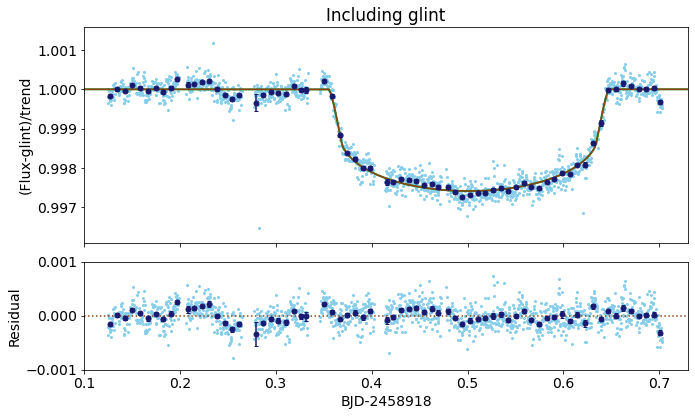

In [21]:
dd.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
              title='Including glint');
plt.ylim([-0.001, 0.001])

(-0.001, 0.001)

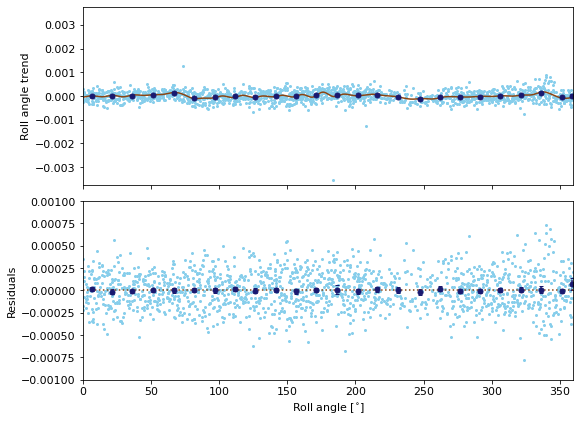

In [22]:
fig = dd.rollangle_plot()
plt.ylim([-0.001, 0.001])

#### Adding moon-glint

Apparently, when the observations were taken, moon was very near ($\sim 16^\circ$) to the target star. And the position of the moon changes significantlly during the observations. Therefore we may want to correct for this effect. Now, since we have already corrected for glint, we want to mask the transit and perform this moon gling only over out of transit points. To do so we create a mask. Then we will add moon glint for out of transit points

(-0.001, 0.001)

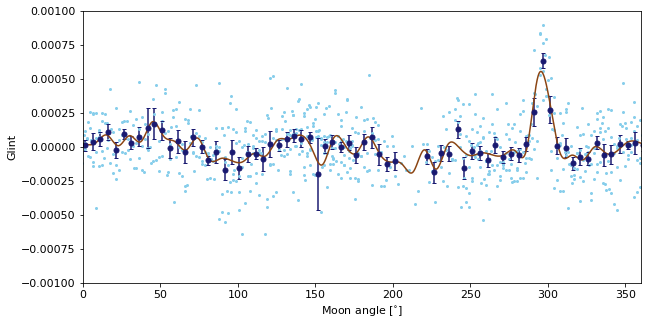

In [23]:
phase = phaser(tim,lmfit.params['P'],lmfit.params['T_0'],-0.5)
mask = abs(phase) < lmfit.params['W']/2

moon_glint = dd.add_glint(moon=True,nspline=48,binwidth=5,
                          fit_flux=True, mask=mask,
                          figsize=(10,5))

plt.ylim([-0.001, 0.001])

In [24]:
dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=star.h_1, h_2=star.h_2.n,
                 logrhoprior=star.logrho, **detrend,
                 glint_scale=(0,2))
 
print(dd.lmfit_report(min_correl=0.5))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 303
    # data points      = 1504
    # variables        = 13
    chi-square         = 3014.05391
    reduced chi-square = 2.02149826
    Akaike info crit   = -20481.3932
    Bayesian info crit = -20412.2867
    RMS residual       = 227.1 ppm
[[Variables]]
    T_0:          0.50159161 +/- 0.00141842 (0.28%) (init = 0.5010961)
    P:            4.736205 (fixed)
    D:            0.00220666 +/- 2.8026e-05 (1.27%) (init = 0.0022)
    W:            0.06263346 +/- 0.00231538 (3.70%) (init = 0.06279289)
    b:            0.47421784 +/- 0.01514529 (3.19%) (init = 0.5)
    f_c:         -0.01606136 +/- 0.01979811 (123.27%) (init = -0.02262488)
    f_s:          0.16211849 +/- 0.16271382 (100.37%) (init = 0.1753428)
    h_1:          0.69812626 +/- 0.00811505 (1.16%) (init = 0.715)
    h_2:          0.442 (fixed)
    c:            0.99995638 +/- 1.3871e-05 (0.00%) (init = 1)
    dfdbg:        2.0863e-04 +/- 6.2203e-05 (

We now have added another parameters for glint in the fitting. This may make some of the decorrelation parameters obsolete. So we can again see if any of the parameters have Bayes' factor larger than unity and if so then remove that parameters.

In [25]:
worstbf = 10
while worstbf > 1:
    worstbf = 0
    for p in detrend: # This loop finds the parameter with largest Bayes' factor
        bre = re.compile(r'{}: *(\d+\.\d{{3}})\n'.format(p))
        m = bre.findall(dd.lmfit_report())
        if len(m) > 0:
            bf = float(m[-1])
            if bf > worstbf:
                worstbf = bf
                delpar = p
    if worstbf > 1: # This condition removes the parameter with largest Bayes' factor if it is >1
        del detrend[delpar] 
        lmfit = dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                      D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                      f_c=f_c, f_s=f_s, 
                      h_1=star.h_1, h_2=star.h_2.n,
                      logrhoprior=star.logrho, **detrend)
        print(f'-{delpar:<12s} {worstbf:6.2f}  {lmfit.bic-lmfit0.bic:8.1f} {1e6*lmfit.rms:8.1f}')

## Fitting for the rest of the parameters
dd.lmfit_transit(T_0 = ufloat(T_0, 0.001), P=P, 
                 D=(D/4, D, D*4), W=(W/4, W, W*4),b=(0,0.5,1),
                 f_c=f_c, f_s=f_s, 
                 h_1=star.h_1, h_2=star.h_2.n,
                 logrhoprior=star.logrho, **detrend,
                 glint_scale=(0,2))
 
print(dd.lmfit_report(min_correl=0.5))

-dfdcos3phi     5.08    -472.1    235.0
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 149
    # data points      = 1504
    # variables        = 12
    chi-square         = 3015.02237
    reduced chi-square = 2.02079247
    Akaike info crit   = -20482.4247
    Bayesian info crit = -20418.6341
    RMS residual       = 227.1 ppm
[[Variables]]
    T_0:          0.50170078 +/- 0.00141899 (0.28%) (init = 0.5010961)
    P:            4.736205 (fixed)
    D:            0.00216220 +/- 5.0334e-05 (2.33%) (init = 0.0022)
    W:            0.06192461 +/- 0.00197277 (3.19%) (init = 0.06279289)
    b:            0.39925115 +/- 0.08490399 (21.27%) (init = 0.5)
    f_c:         -0.04102949 +/- 0.09049133 (220.55%) (init = -0.02262488)
    f_s:          0.09472134 +/- 0.19381099 (204.61%) (init = 0.1753428)
    h_1:          0.69424969 +/- 0.00797668 (1.15%) (init = 0.715)
    h_2:          0.442 (fixed)
    c:            0.99995371 +/- 1.3891e-05 (0.00%) (init = 1)
    

And let's now see the roll-angle plot...

(-0.001, 0.001)

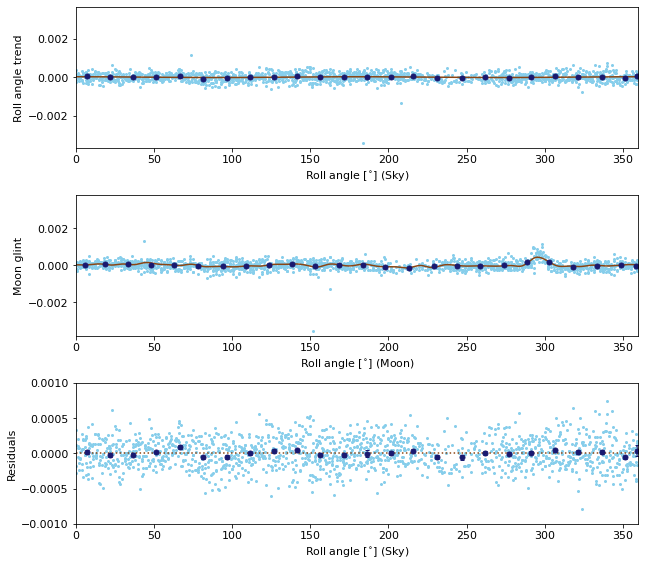

In [26]:
fig = dd.rollangle_plot()
plt.ylim([-0.001, 0.001])

And our fitting,

(-0.001, 0.001)

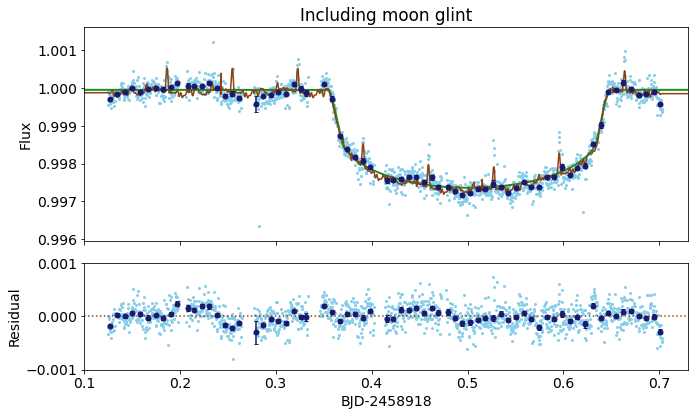

In [27]:
dd.plot_lmfit(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=False,
              title='Including moon glint');
plt.ylim([-0.001, 0.001])

## GP Fitting

The small variations present in the residual panel of the above figure shows very the inherent stellar variability due to convection and granulation. We can model this 'noise' using the Gaussian processes. In `pycheops` we can implement `SHOTerm` kernel of `celerite` package to model this variations. The posterior probability distribution is then sampled using `emcee`. `SHOTerm` is a three parameter kernel: $\sigma$ (the amplitude of the jitter), $\omega_0$ (related to the correlations in the timescale) and $S_0$ (related to the amplitude of the correlated noise).

This kind of GP fitting in `pycheops` can be implemented using `dataset.emcee_sampler` function as shown below.

### GP fitting with fixing transit parameters
If, while modelling, one let the transit parameters, decorrelation parameters and GP parameters free then the results would have much more variability in flux than what is in CHEOPS flux (meaning that GP is fitting transit model as noise). So, what we do is, first fix the transit parameters to the values predicted from `lmfit_transit` operation that we just did. That way we would have a good primary priors on GP parameters. Then, in the next step we would let transit and GP parameters free to find the final fitting.

In [28]:
# This code if from the pycheops notebook
# Copy the parameters from the last lmfit
params_fixed = dd.lmfit.params.copy() 

# Fix the transit parameters
for p in ['T_0','D','W','b']:
    params_fixed[p].set(vary=False)

# Use emcee to sample the PPD. Note we add the SHOTerm at this step.
# add_shorterm determines whether to include short term noise in the modelling or not.
result = dd.emcee_sampler(params=params_fixed, add_shoterm=True, 
                          burn=512,steps=256,nwalkers=128)

print(dd.emcee_report(min_correl=0.5))

Running burn-in ..


100%|██████████| 512/512 [07:09<00:00,  1.19it/s]

Running sampler ..



100%|██████████| 256/256 [03:13<00:00,  1.32it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 88483
    # data points      = 1504
    # variables        = 11
    chi-square         = 3032.96800
    reduced chi-square = 2.03145881
    Akaike info crit   = -21184.5933
    Bayesian info crit = -21126.1185
    RMS residual       = 227.7 ppm
[[Variables]]
    T_0:          0.5017008 (fixed)
    P:            4.736205 (fixed)
    D:            0.002162203 (fixed)
    W:            0.06192461 (fixed)
    b:            0.3992511 (fixed)
    f_c:          0.00688281 +/- 0.18128952 (2633.95%) (init = -0.02262488)
    f_s:          0.04891767 +/- 0.04570975 (93.44%) (init = 0.1753428)
    h_1:          0.70974982 +/- 0.00978868 (1.38%) (init = 0.715)
    h_2:          0.442 (fixed)
    c:            0.99995287 +/- 2.6902e-05 (0.00%) (init = 1)
    dfdbg:        2.3463e-04 +/- 5.7949e-05 (24.70%) (init = 0)
    dfdcontam:   -1.5096e-04 +/- 6.3285e-05 (41.92%) (init = 0)
    dfdcos2phi:   1.8974e-05 +/- 2.1717e-05 (1

Let's plot the result...

As previous, the green curve shows the transit model, while the brown curve is the best fit (maximum likelihood) model that includes the trends, glints and GP model. The bottom panel shows the residuals <i>without</i> GP models. That means what is shows is flux - (transit model $\times$ trend + glint). The GP noise model is shown in brown.

(-0.001, 0.001)

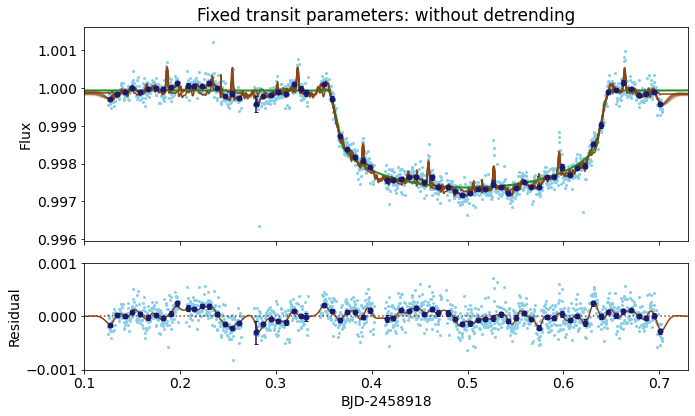

In [29]:
fig  = dd.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14,
                     title='Fixed transit parameters: without detrending')

plt.ylim([-0.001, 0.001])

(-0.001, 0.001)

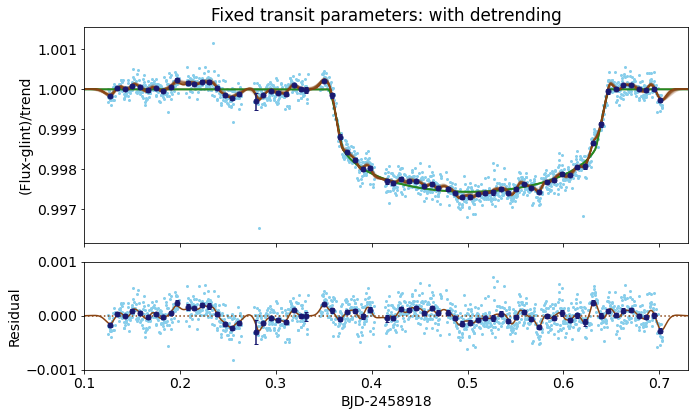

In [30]:
fig  = dd.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                     title='Fixed transit parameters: with detrending')
plt.ylim([-0.001, 0.001])

We can see that the (partial) GP model indeed did a good job in fitting the noise. We now implement a full GP model.

### Full GP fitting

Now, we free all the parameters and see how the fitting goes. In this setting, we create Gaussian priors on the noise model parameters: with mean of the posteriors from previous fit and standard deviation twice the width of the distribution. This would keep the noise parameters within the bound.

In [31]:
# Parameters spitted out by emcee fit
dd.emcee.params

Parameters([('T_0',
             <Parameter 'T_0', value=0.501700784501301 (fixed), bounds=[-inf:inf]>),
            ('P',
             <Parameter 'P', value=4.73620495 (fixed), bounds=[-inf:inf]>),
            ('D',
             <Parameter 'D', value=0.0021622030991960374 (fixed), bounds=[0.00055:0.0088]>),
            ('W',
             <Parameter 'W', value=0.06192460573447586 (fixed), bounds=[0.015698222687766075:0.2511715630042572]>),
            ('b',
             <Parameter 'b', value=0.3992511495489402 (fixed), bounds=[0:1]>),
            ('f_c',
             <Parameter 'f_c', value=0.0068828083934389175 +/- 0.181, bounds=[-inf:inf]>),
            ('f_s',
             <Parameter 'f_s', value=0.04891766858246505 +/- 0.0457, bounds=[-inf:inf]>),
            ('h_1',
             <Parameter 'h_1', value=0.7097498228759298 +/- 0.00979, bounds=[-inf:inf]>),
            ('h_2', <Parameter 'h_2', value=0.442 (fixed), bounds=[-inf:inf]>),
            ('c',
             <Parameter 'c', value=0.9999528720565315 +/- 2.69e-05, bounds=[0.4981783809798544:2.002426640335513]>),
            ('dfdbg',
             <Parameter 'dfdbg', value=0.00023463448715082532 +/- 5.79e-05, bounds=[-inf:inf]>),
            ('dfdcontam',
             <Parameter 'dfdcontam', value=-0.00015096286176889516 +/- 6.33e-05, bounds=[-inf:inf]>),
            ('dfdcos2phi',
             <Parameter 'dfdcos2phi', value=1.897411330953797e-05 +/- 2.17e-05, bounds=[-inf:inf]>),
            ('glint_scale',
             <Parameter 'glint_scale', value=0.7477863457172036 +/- 0.0775, bounds=[0:2]>),
            ('k',
             <Parameter 'k', value=0.04649949568754523 +/- 0.000541, bounds=[0:1], expr='sqrt(D)'>),
            ('aR',
             <Parameter 'aR', value=4.972434250305286 +/- 0.244, bounds=[1:inf], expr='sqrt((1+k)**2-b**2)/W/pi'>),
            ('sini',
             <Parameter 'sini', value=0.9967713131613529 +/- 0.00138, bounds=[-inf:inf], expr='sqrt(1 - (b/aR)**2)'>),
            ('logrho',
             <Parameter 'logrho', value=-1.1334671324146361 +/- 0.0641, bounds=[-9:6], expr='log10(4.3275e-4*((1+k)**2-b**2)**1.5/W**3/P**2)'>),
            ('e',
             <Parameter 'e', value=0.002440311350924682 +/- 0.0436, bounds=[0:1], expr='f_c**2 + f_s**2'>),
            ('q_1',
             <Parameter 'q_1', value=0.3113640000000001 +/- 0, bounds=[0:1], expr='(1-h_2)**2'>),
            ('q_2',
             <Parameter 'q_2', value=0.4798383922507702 +/- 0.0143, bounds=[0:1], expr='(h_1-h_2)/(1-h_2)'>),
            ('log_S0',
             <Parameter 'log_S0', value=-23.313259041007893 +/- 0.309, bounds=[-30:0]>),
            ('log_omega0',
             <Parameter 'log_omega0', value=5.582394615805311 +/- 0.154, bounds=[-2.3:8]>),
            ('log_Q',
             <Parameter 'log_Q', value=-0.34657359027997275 (fixed), bounds=[-inf:inf]>),
            ('log_sigma',
             <Parameter 'log_sigma', value=-9.058720778773234 +/- 0.0573, bounds=[-16:-1]>),
            ('sigma_w',
             <Parameter 'sigma_w', value=116.37174661870621, bounds=[-inf:inf], expr='exp(log_sigma)*1e6'>)])

In [32]:
# First we copy the posteriors from emcee fitting to a dictionary which we can use as prior in this fitting
params_free = dd.emcee.params.copy()

# Changing the priors on the noise parameters
for i in ['log_S0', 'log_omega0', 'log_sigma']:
    params_free.user_data = ufloat(params_free[p].value, 2*params_free[p].stderr)

# Letting the transit model parameters free

for p in ['T_0', 'D', 'W', 'b']:
    params_free[p].set(vary=True)

# Running emcee
result = dd.emcee_sampler(params=params_free, burn=512, steps=265, nwalkers=256)
print(dd.emcee_report())

Running burn-in ..


100%|██████████| 512/512 [13:01<00:00,  1.53s/it]

Running sampler ..



100%|██████████| 265/265 [07:22<00:00,  1.67s/it]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 269943
    # data points      = 1504
    # variables        = 15
    chi-square         = 3032.62414
    reduced chi-square = 2.03668512
    Akaike info crit   = -21178.1662
    Bayesian info crit = -21098.4280
    RMS residual       = 227.7 ppm
[[Variables]]
    T_0:          0.50190975 +/- 5.7001e-04 (0.11%) (init = 0.5010961)
    P:            4.736205 (fixed)
    D:            0.00212461 +/- 6.0577e-05 (2.85%) (init = 0.0022)
    W:            0.06287471 +/- 0.00152432 (2.42%) (init = 0.06279289)
    b:            0.30386263 +/- 0.15258452 (50.21%) (init = 0.5)
    f_c:          0.00401860 +/- 0.22597707 (5623.28%) (init = -0.02262488)
    f_s:          0.11406965 +/- 0.10640627 (93.28%) (init = 0.1753428)
    h_1:          0.70944838 +/- 0.01087593 (1.53%) (init = 0.715)
    h_2:          0.442 (fixed)
    c:            0.99995600 +/- 3.3808e-05 (0.00%) (init = 1)
    dfdbg:        2.2967e-04 +/- 5.7984e-05

Let's first see roll-angle plot,

(-0.001, 0.001)

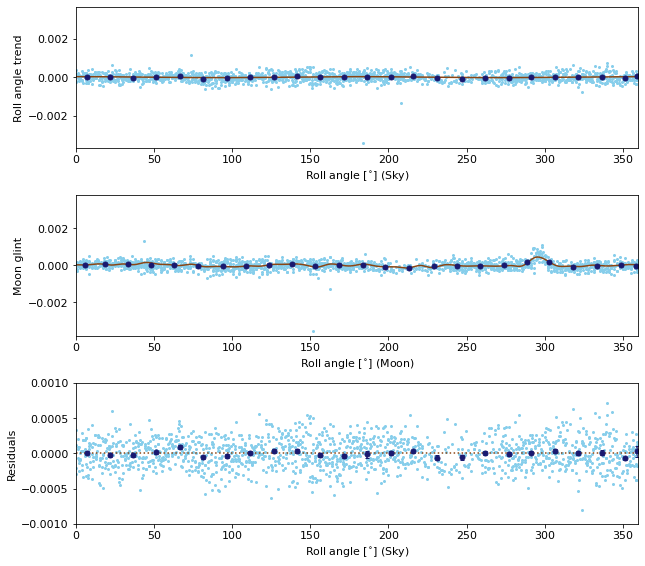

In [33]:
fig = dd.rollangle_plot()
plt.ylim([-0.001, 0.001])

and the trail plot (or the MCMC chains) to ensure that the convergence is indeed reached.

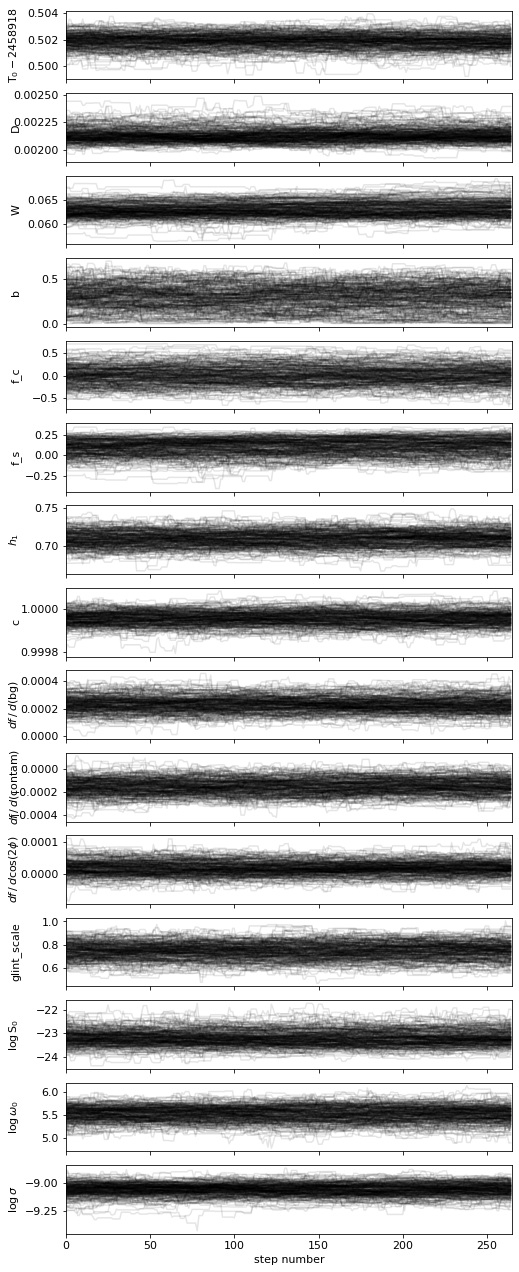

In [34]:
fig = dd.trail_plot('all')

And, now finally the plot of transit fitting (with and without detrending),

(-0.001, 0.001)

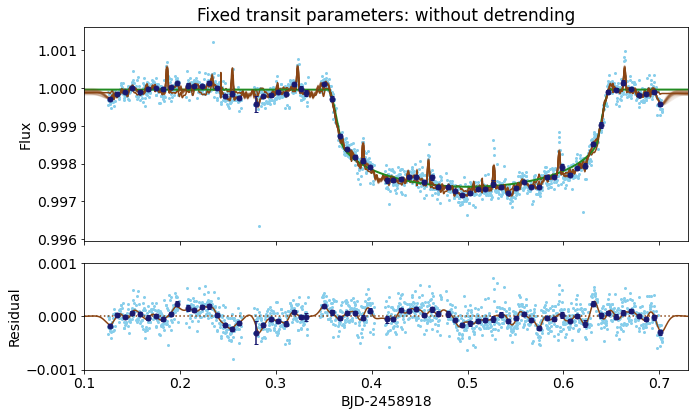

In [35]:
fig  = dd.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14,
                     title='Fixed transit parameters: without detrending')
plt.ylim([-0.001, 0.001])

(-0.001, 0.001)

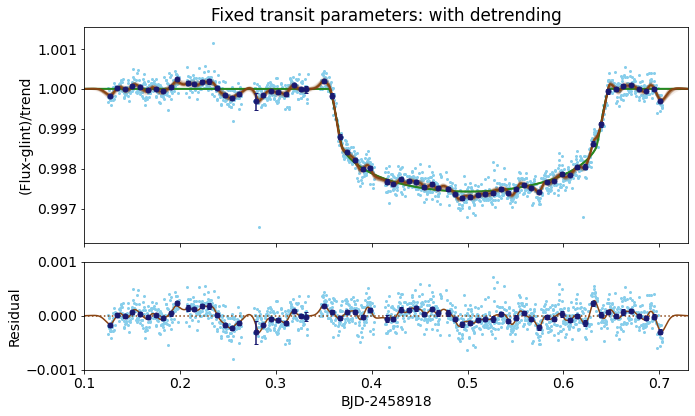

In [36]:
fig  = dd.plot_emcee(binwidth=0.008, figsize=(10,6), fontsize=14, detrend=True,
                     title='Fixed transit parameters: with detrending')
plt.ylim([-0.001, 0.001])

#### Corner plots

We can now make corner plots of the parameters to see their posterior probability distribution. Dashed green line on the histograms indicates the $\pm 1-\sigma$ limits on the Gaussian priors of the given parameter.

We first make the corner plot for the noise model parameters.

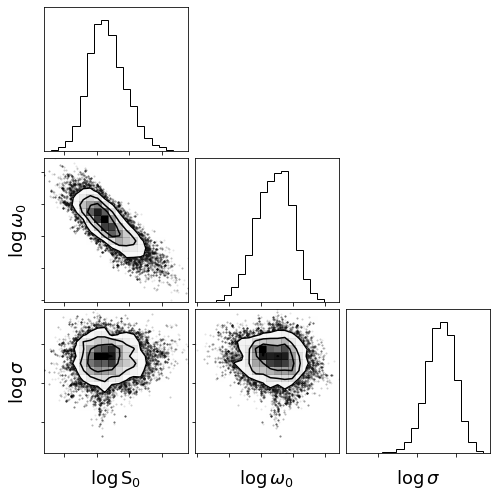

In [37]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal','size': 18}
fig = dd.corner_plot(
    plotkeys=['log_S0','log_omega0','log_sigma'],
    kwargs={'label_kwargs':{'fontdict':font}})

and the same plot for all of the parameters.

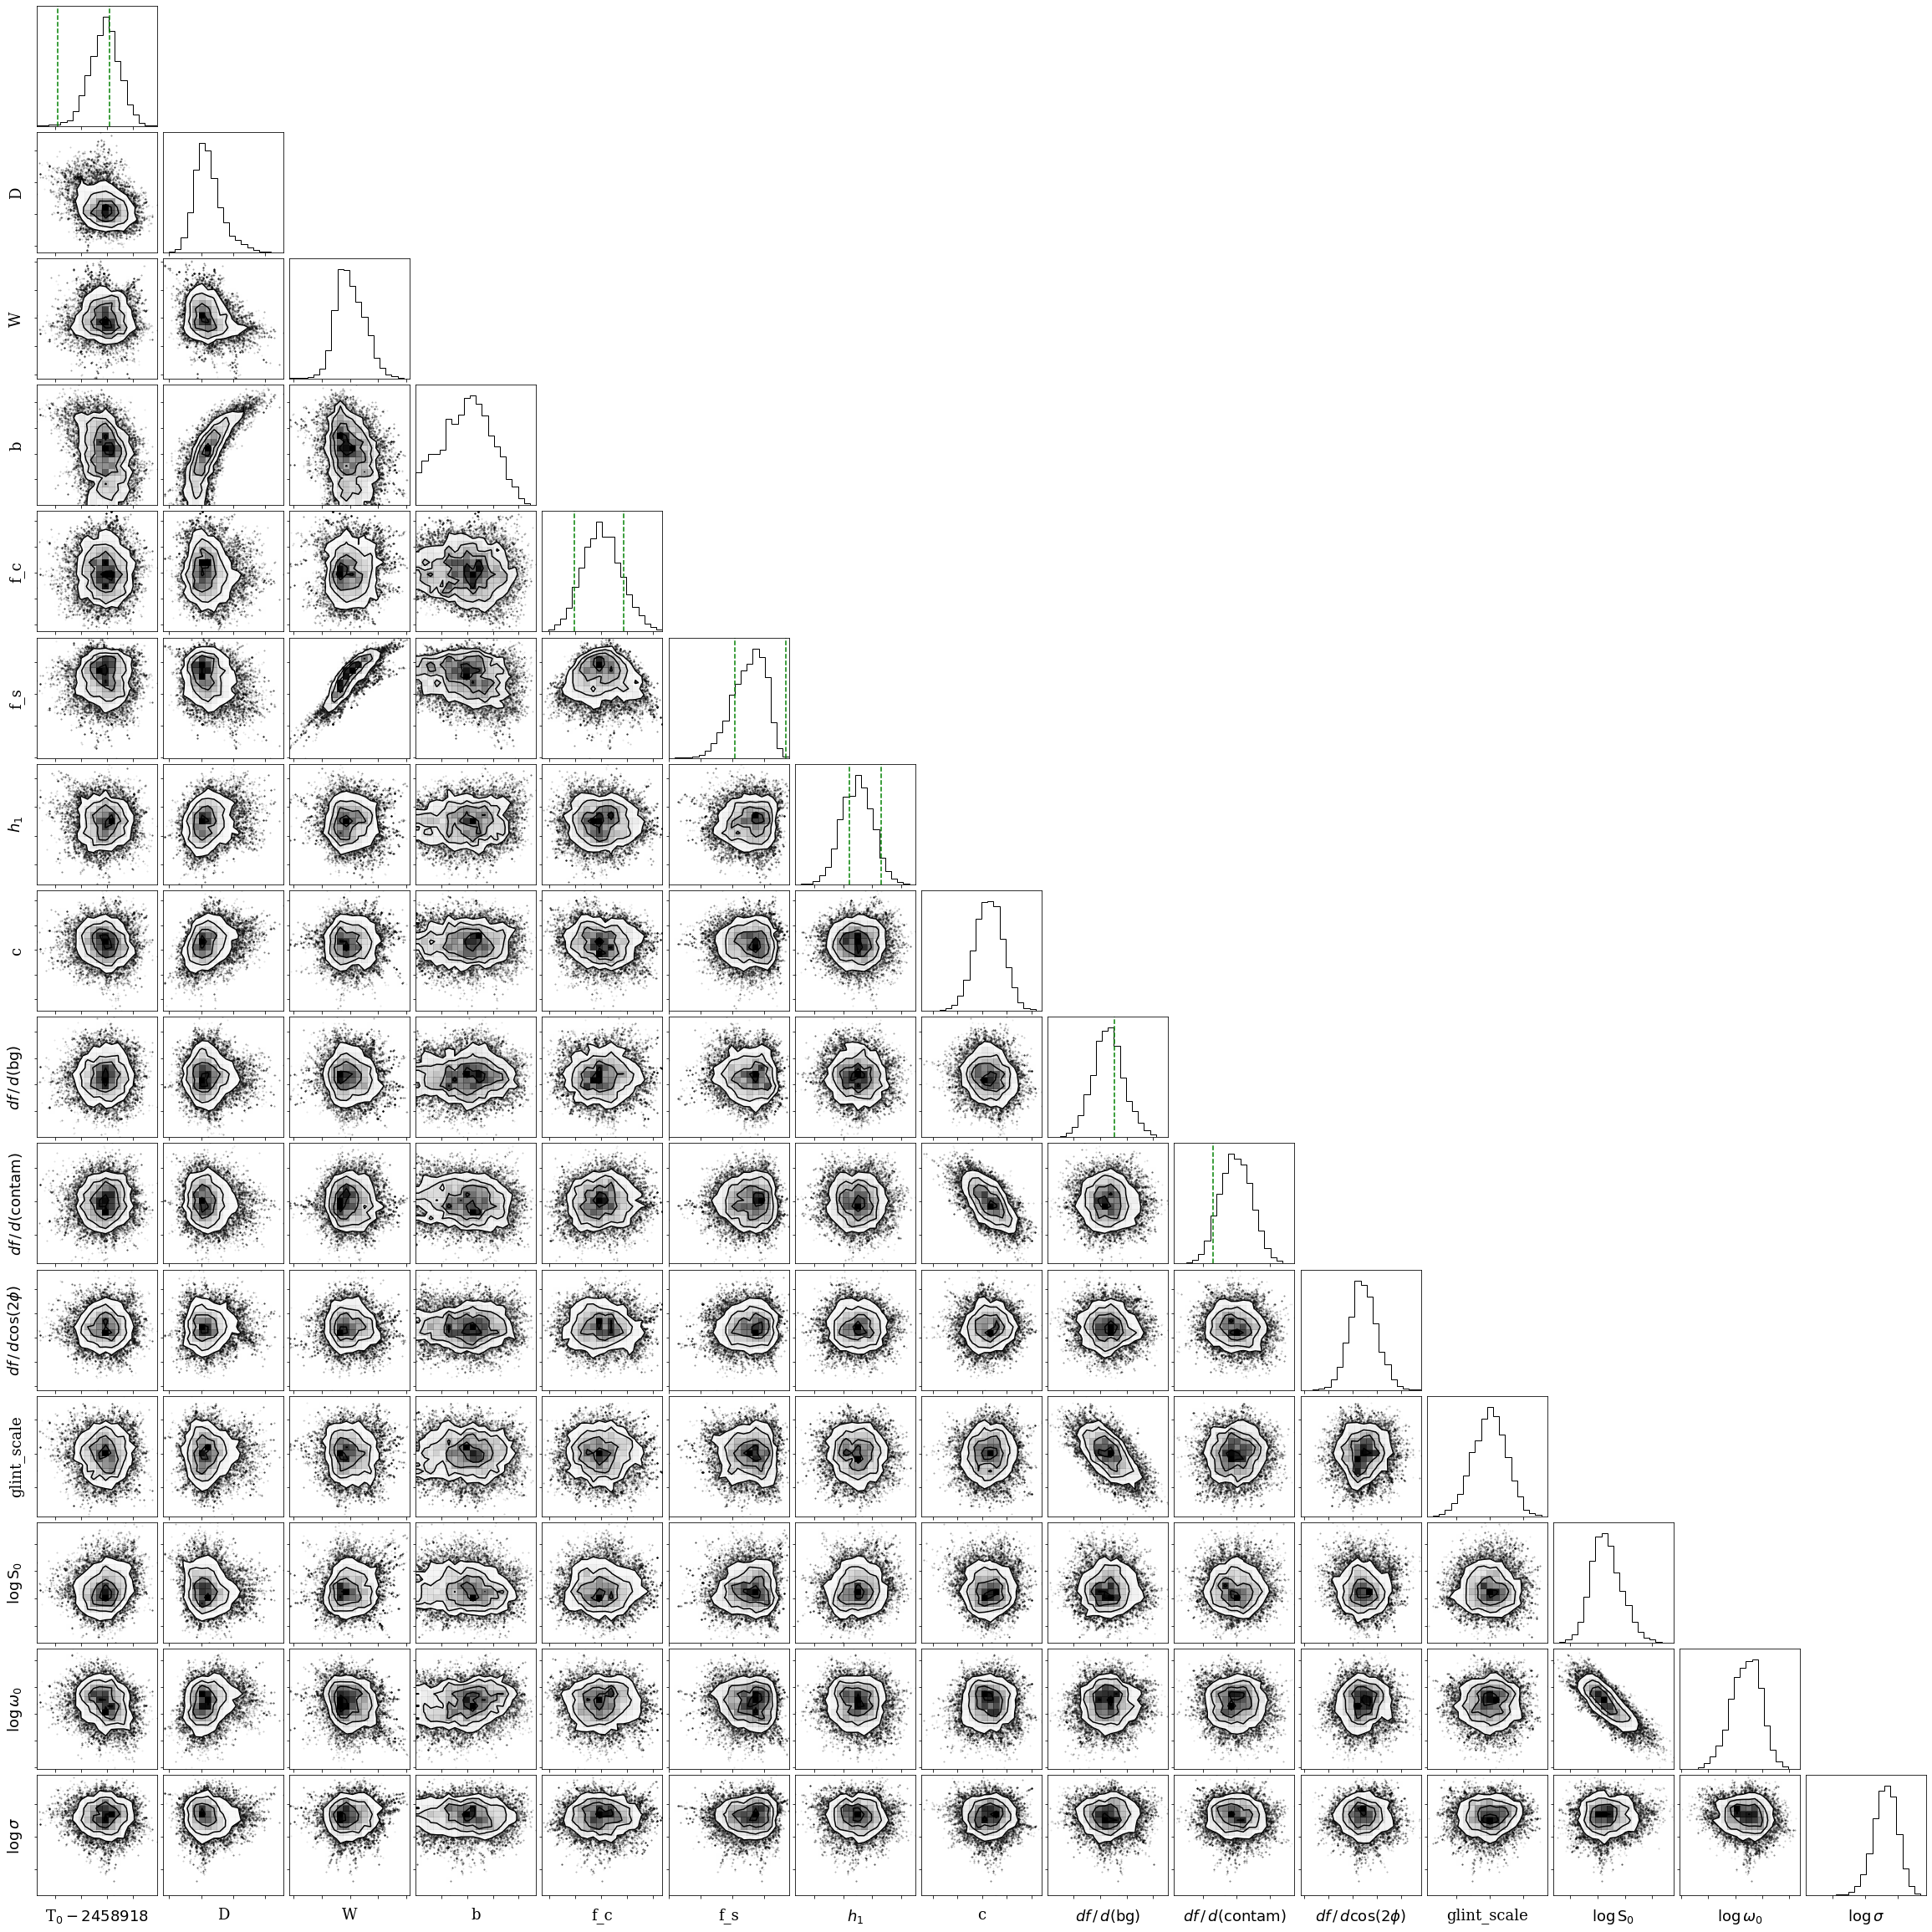

In [38]:
fig = dd.corner_plot(plotkeys='all', kwargs={'label_kwargs':{'fontdict':font}})

#### FFT of the residuals

We can compute Lomb-Scargle power-spectrum of the residuals --- this can show if there is any periodic signal hidden in the residuals (after GP subtraction).

The red dotted vertical lines show the CHEOPS orbital frequency and its first two harmonics.

The likely range of the peak power for stellar oscillation is shown using green dashed lines.

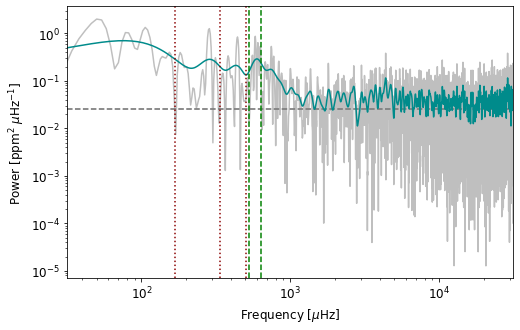

In [39]:
fig = dd.plot_fft(star, gsmooth=10)

In [40]:
result.params

Parameters([('T_0',
             <Parameter 'T_0', value=0.5019097461131984 +/- 0.00057, bounds=[-inf:inf]>),
            ('P',
             <Parameter 'P', value=4.73620495 (fixed), bounds=[-inf:inf]>),
            ('D',
             <Parameter 'D', value=0.002124610205956307 +/- 6.06e-05, bounds=[0.00055:0.0088]>),
            ('W',
             <Parameter 'W', value=0.06287471076524112 +/- 0.00152, bounds=[0.015698222687766075:0.2511715630042572]>),
            ('b',
             <Parameter 'b', value=0.30386263168635097 +/- 0.153, bounds=[0:1]>),
            ('f_c',
             <Parameter 'f_c', value=0.004018598481925059 +/- 0.226, bounds=[-inf:inf]>),
            ('f_s',
             <Parameter 'f_s', value=0.11406964684419349 +/- 0.106, bounds=[-inf:inf]>),
            ('h_1',
             <Parameter 'h_1', value=0.7094483758924199 +/- 0.0109, bounds=[-inf:inf]>),
            ('h_2', <Parameter 'h_2', value=0.442 (fixed), bounds=[-inf:inf]>),
            ('c',
             <Parameter 'c', value=0.9999560005742338 +/- 3.38e-05, bounds=[0.4981783809798544:2.002426640335513]>),
            ('dfdbg',
             <Parameter 'dfdbg', value=0.0002296685493955385 +/- 5.8e-05, bounds=[-inf:inf]>),
            ('dfdcontam',
             <Parameter 'dfdcontam', value=-0.00015378358282857251 +/- 7.23e-05, bounds=[-inf:inf]>),
            ('dfdcos2phi',
             <Parameter 'dfdcos2phi', value=1.6536741840545504e-05 +/- 2.23e-05, bounds=[-inf:inf]>),
            ('glint_scale',
             <Parameter 'glint_scale', value=0.7493739371605421 +/- 0.0749, bounds=[0:2]>),
            ('k',
             <Parameter 'k', value=0.04609349418254497 +/- 0.000541, bounds=[0:1], expr='sqrt(D)'>),
            ('aR',
             <Parameter 'aR', value=5.0676131962093445 +/- 0.244, bounds=[1:inf], expr='sqrt((1+k)**2-b**2)/W/pi'>),
            ('sini',
             <Parameter 'sini', value=0.9982006793232951 +/- 0.00138, bounds=[-inf:inf], expr='sqrt(1 - (b/aR)**2)'>),
            ('logrho',
             <Parameter 'logrho', value=-1.1087639049329747 +/- 0.0641, bounds=[-9:6], expr='log10(4.3275e-4*((1+k)**2-b**2)**1.5/W**3/P**2)'>),
            ('e',
             <Parameter 'e', value=0.013028033464917953 +/- 0.0436, bounds=[0:1], expr='f_c**2 + f_s**2'>),
            ('q_1',
             <Parameter 'q_1', value=0.3113640000000001 +/- 0, bounds=[0:1], expr='(1-h_2)**2'>),
            ('q_2',
             <Parameter 'q_2', value=0.4792981646817561 +/- 0.0143, bounds=[0:1], expr='(h_1-h_2)/(1-h_2)'>),
            ('log_S0',
             <Parameter 'log_S0', value=-23.23266595582334 +/- 0.334, bounds=[-30:0]>),
            ('log_omega0',
             <Parameter 'log_omega0', value=5.528014620237983 +/- 0.168, bounds=[-2.3:8]>),
            ('log_Q',
             <Parameter 'log_Q', value=-0.34657359027997275 (fixed), bounds=[-inf:inf]>),
            ('log_sigma',
             <Parameter 'log_sigma', value=-9.056472272095037 +/- 0.0544, bounds=[-16:-1]>),
            ('sigma_w',
             <Parameter 'sigma_w', value=116.63370366384794, bounds=[-inf:inf], expr='exp(log_sigma)*1e6'>)])